In [106]:
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import numpy as np
import pandas as pd
#import xml.etree.ElementTree as ET
import xarray as xr
#import hvplot.xarray
#import rasterio as rio
import pickle
from matplotlib import cm
from rasterio.plot import show
from datetime import datetime
# from scipy import interpolate
# from astropy.convolution import Gaussian2DKernel, convolve

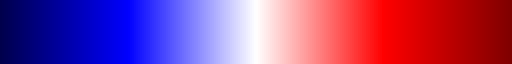

In [107]:
# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']
ored3 = ['#fee8c8','#fdbb84','#e34a33']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')

ygbmap = cm.YlGnBu_r.copy()
ygbmap.set_bad(color='darkgray')

prmap = cm.PuRd.copy()
prmap.set_bad(color='darkgray')

dcmap

In [108]:
def running_mean(y, npts):
    '''
    Smooth a 1-d array with a moving average
    https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

    Input:
        y - 1-d array
        npts - number of points to average
    Returns:
        ys - smoothed arrays
    '''
    box = np.ones(npts)/npts
    ys = np.convolve(y, box, mode='same')
    return ys

In [109]:
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/dorian_032/dorian_his.ncml'

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:                 (tracer: 2, NST: 1, s_rho: 5, s_w: 6,
                             eta_rho: 1017, xi_rho: 1317, eta_u: 1017,
                             xi_u: 1316, eta_v: 1016, xi_v: 1317,
                             eta_psi: 1016, xi_psi: 1316, ocean_time: 24,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9 -0.7 -0.5 -0.3 -0.1
  * s_w                     (s_w) float64 -1.0 -0.8 -0.6 -0.4 -0.2 0.0
    lon_rho                 (eta_rho, xi_rho) float64 ...
    lat_rho                 (eta_rho, xi_rho) float64 ...
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T11:14:59.9...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/173)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00016.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  ./ROMS/External/varinfo.dat
    ...                        ...
    tiling:                    021x012
    history:                   ROMS/TOMS, Version 3.9, Monday - May 9, 2022 -...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         5
    EXTRA_DIMENSION.boundary:  4

url31='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/dorian_031/dorian_his.ncml'
ds31 = xr.open_dataset(url31)
ds31

In [110]:
### pre/post bathy for

In [111]:
bathy32_4 = -ds.bath[4,:,:]
bathy32_23 = -ds.bath[23,:,:]
bathy31_4 = -ds31.bath[4,:,:]
bathy31_23 = -ds31.bath[23,:,:]

In [112]:
dx, dy = 1./.66, 1./.66
xs, xe = 650, 1050
ys, ye = 100, 500
subx = range(xs,xe+1)
suby = range(ys,ye+1)
xm = np.arange(0., len(subx))
ym = np.arange(0., len(suby))

prx = 858
pry = 205


t=ds.ocean_time
tstring = np.datetime_as_string(t, unit='m')
tstring.shape
tstring

In [113]:
tstring=pd.to_datetime(t).strftime('%Y-%m-%d %H%m')
tstring

Index(['2019-09-06 1109', '2019-09-06 1109', '2019-09-06 1109',
       '2019-09-06 1209', '2019-09-06 1209', '2019-09-06 1209',
       '2019-09-06 1209', '2019-09-06 1309', '2019-09-06 1309',
       '2019-09-06 1309', '2019-09-06 1309', '2019-09-06 1409',
       '2019-09-06 1409', '2019-09-06 1409', '2019-09-06 1409',
       '2019-09-06 1409', '2019-09-06 1509', '2019-09-06 1509',
       '2019-09-06 1509', '2019-09-06 1609', '2019-09-06 1609',
       '2019-09-06 1609', '2019-09-06 1609', '2019-09-06 1709'],
      dtype='object')

Text(0.75, 0.9, 'Difference')

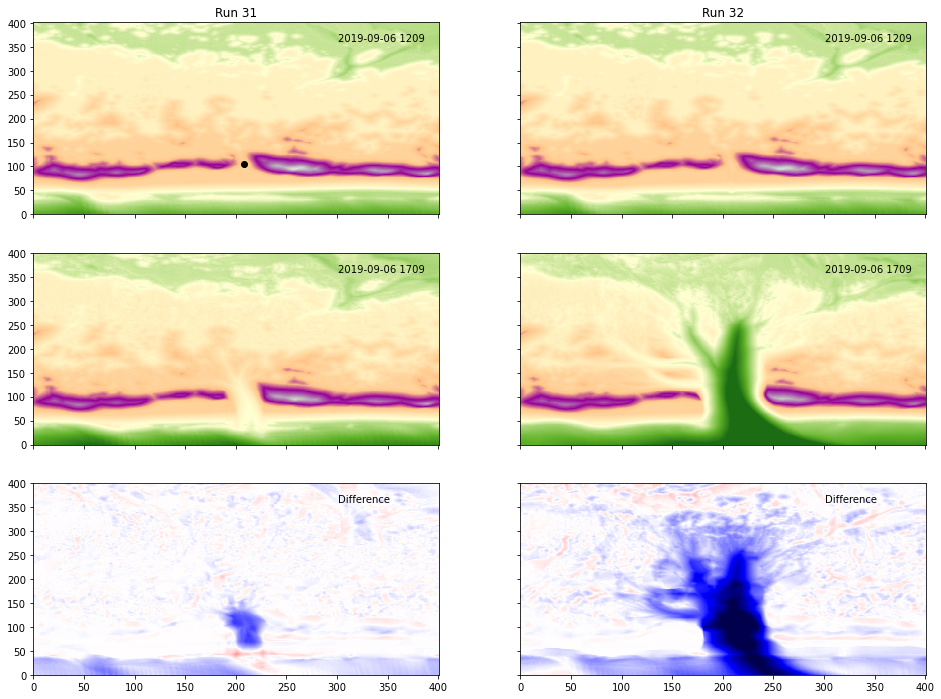

In [114]:
fig, ax = plt.subplots(3,2,figsize=(16,12),sharex=True,sharey=True)
                     
ax[0,0].title.set_text('Run 31')
p00=ax[0,0].pcolormesh(bathy31_4[suby,subx],cmap=tcmap,vmin=-2,vmax=6)
ax[0,0].text(0.75, 0.9, tstring[4], transform=ax[0,0].transAxes)
#plt.colorbar(p00,ax=ax[0,0])
ax[0,0].plot(prx-xs,pry-ys,'ok')

ax[1,0].pcolormesh(bathy31_23[suby,subx],cmap=tcmap,vmin=-2,vmax=6)
ax[1,0].text(0.75, 0.9, tstring[23], transform=ax[1,0].transAxes)

ax[2,0].pcolormesh( (bathy31_23-bathy31_4)[suby,subx],cmap=dcmap,vmin=-4,vmax=4)
ax[2,0].text(0.75, 0.9, 'Difference', transform=ax[2,0].transAxes)


ax[0,1].title.set_text('Run 32')
ax[0,1].pcolormesh(bathy32_4[suby,subx],cmap=tcmap,vmin=-2,vmax=6)
ax[0,1].text(0.75, 0.9, tstring[4], transform=ax[0,1].transAxes)

ax[1,1].pcolormesh(bathy32_23[suby,subx],cmap=tcmap,vmin=-2,vmax=6)
ax[1,1].text(0.75, 0.9, tstring[23], transform=ax[1,1].transAxes)

ax[2,1].pcolormesh( (bathy32_23-bathy32_4)[suby,subx],cmap=dcmap,vmin=-4,vmax=4)
ax[2,1].text(0.75, 0.9, 'Difference', transform=ax[2,1].transAxes)


(-0.5, 400.5, -0.5, 400.5)

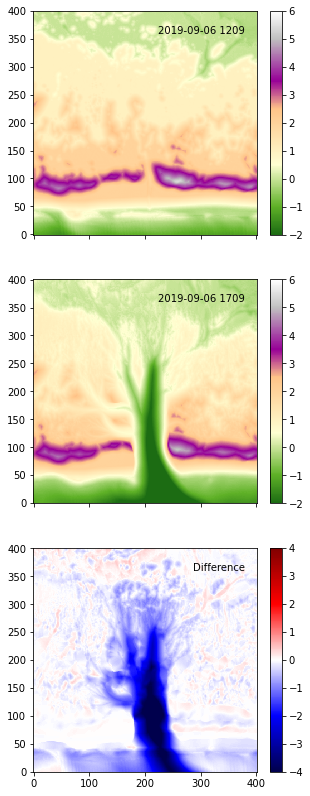

In [115]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(5, 14),sharex=True)
                    
#ax0.title.set_text('Elevation (m)')
m0=ax0.pcolormesh(xm, ym, bathy32_4[suby,subx],cmap=tcmap,vmin=-2,vmax=6)
ax0.text(0.95, 0.9, tstring[4], ha='right', transform=ax0.transAxes)
plt.colorbar(m0, ax=ax0)
ax0.set_xlim([0, np.max(xm)])
ax0.set_ylim([0, np.max(ym)])
ax0.axis('equal')

#ax1.title.set_text('Elevation (m)')
m1=ax1.pcolormesh(xm, ym, bathy32_23[suby,subx],cmap=tcmap,vmin=-2,vmax=6)
ax1.text(0.95, 0.9, tstring[23], ha='right', transform=ax1.transAxes)
plt.colorbar(m1, ax=ax1)
ax1.set_xlim([0, np.max(xm)])
ax1.set_ylim([0, np.max(ym)])
ax1.axis('equal')

#ax2.title.set_text('Difference (m)')
m2=ax2.pcolormesh(xm, ym, (bathy32_23-bathy32_4)[suby,subx],cmap=dcmap,vmin=-4,vmax=4)
ax2.text(0.95, 0.9, 'Difference', ha='right', transform=ax2.transAxes)
plt.colorbar(m2, ax=ax2)
ax2.set_xlim([0, np.max(xm)])
ax2.set_ylim([0, np.max(ym)])
ax2.axis('equal')

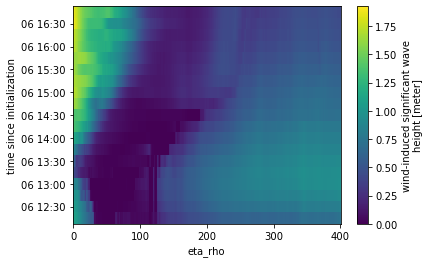

In [116]:
ds.Hwave[4:23,suby,prx].plot()

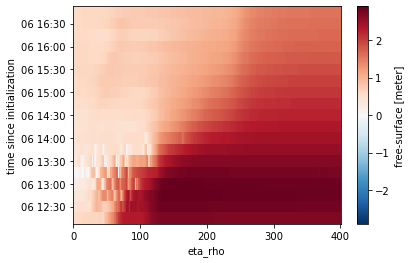

In [117]:
ds.zeta[4:23,suby,prx].plot()

In [118]:
wdm = ds.wetdry_mask_rho[14,:,:]
zeta = ds.zeta[14,:,:]
wdm_shape = wdm.shape
print(wdm_shape)
wdmr = np.ravel(wdm)
zetar = np.ravel(zeta)
zetar[np.where(wdmr==0.)]=np.nan
zeta = np.reshape(zetar, wdm_shape)
print(np.sum(np.isnan(zeta)))

(1017, 1317)
133698


In [119]:
zetap = ds.zeta[:,:,prx-1:prx+2].load()
zetap = np.nanmean(zetap,2)

In [120]:
bp = ds.bath[:,:,prx-1:prx+2].load()
bp = np.nanmean(bp,2)

In [121]:
wm = ds.wetdry_mask_rho[:,:,prx-1:prx+2].load()
wm = np.nanmean(wm,2)

In [122]:
# nan out zeta where wetdry_mask == 0
wm_shape = wm.shape
wmr = np.ravel(wm)
zr = np.ravel(zetap)
zr[np.where(wmr==0.)]=np.nan
zetap = np.reshape(zr, wm_shape)

In [123]:
# average three transects
zetap.shape

(24, 1017)

In [124]:
# smooth w/ running mean
zetaps = np.nan*np.ones_like(zetap)
for i in range(24):
    zetaps[i] = running_mean( zetap[i,:],21)

In [125]:
dy = 1.
slope = np.diff(zetaps,1)/dy

In [126]:
print(zetap.shape)
print(slope.shape)
mx_slope = np.max(slope,1)
dt = 0.25
sim_hour = np.arange(0.,24*dt,dt)

(24, 1017)
(24, 1016)


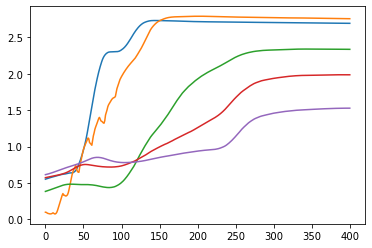

In [127]:
plt.plot(zetaps[4,suby])
plt.plot(zetaps[8,suby])
plt.plot(zetaps[12,suby])
plt.plot(zetaps[16,suby])
plt.plot(zetaps[23,suby])


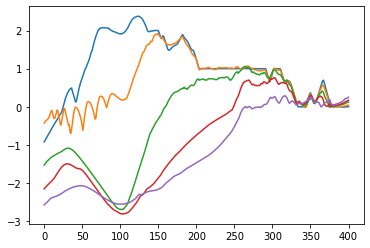

In [128]:

plt.plot(-bp[4,suby])
plt.plot(-bp[8,suby])
plt.plot(-bp[12,suby])
plt.plot(-bp[16,suby])
plt.plot(-bp[23,suby])

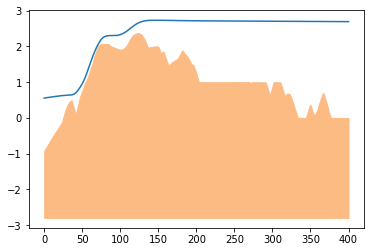

In [129]:
x = np.arange(0.,dy*len(bp[0,suby]))
floor = np.ones_like(bp[0,suby])*-2.8
plt.fill_between(x,-bp[4,suby],floor,color=ored3[1])
plt.plot(x,zetaps[4,suby])

0
0.0
2
0.5
4
1.0
6
1.5
8
2.0
10
2.5
12
3.0
14
3.5
16
4.0
18
4.5


Text(0, 0.5, 'Elevation (m NAVD88)')

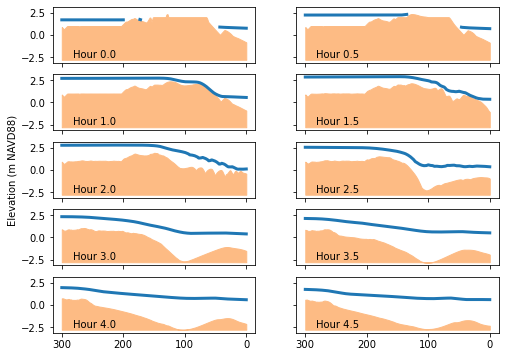

In [56]:
fig, axes = plt.subplots(5,2,figsize=(8,6),sharex=True,sharey=True)
i=0
for ax in (axes.flatten()):
    print(i)
    ax.fill_between(x,-bp[i,suby],floor,color=ored3[1])
    ax.plot(x,zetaps[i,suby],linewidth=3)
    ax.text(0.1, 0.1, 'Hour {:.1f}'.format(sim_hour[i]), transform=ax.transAxes)
    print(sim_hour[i])
    i += 2
    
ax.invert_xaxis()
plt.subplots_adjust(hspace = 0.2)
axes[2,0].set_ylabel('Elevation (m NAVD88)')

In [ ]:
ax.flatten()

In [ ]:



plt.pcolormesh((zeta)[100:400,700:1000],cmap=ygbmap,vmin=0,vmax=3.)
plt.colorbar()
plt.title('Water Surface Elevation (m)')

In [ ]:
ds.zeta.isel(ocean_time=0).plot(x="lon_rho", y="lat_rho")

In [ ]:
ds.bed_thickness.isel(ocean_time=14).plot()

In [ ]:
dmap = ds.bath[-1,0:400,:].plot()


In [ ]:
ds.zeta.isel(ocean_time=0).plot()
plt.plot(600,100,'or')

In [ ]:
ds.zeta.isel(xi_rho=850,eta_rho=100,ocean_time=range(0,15)).plot()
ds.zeta.isel(xi_rho=850,eta_rho=400,ocean_time=range(0,15)).plot()

In [ ]:
ds.zeta[0,200:600,600].plot()
ds.zeta[7,200:600,600].plot()
